In [1]:
from tools.transcripts import *
from tools.psl import *
import pandas as pd
from tools.mathOps import *
from tools.sqlInterface import *
from tools.nameConversions import *
%matplotlib inline
import seaborn as sns
import pysam
from glob import glob
import os

In [2]:
genomes = ["Bonobo"]
new_dir = '/public/groups/cgl/cat/primates_evan/v2/work/transMap/'
old_dir = '/public/groups/cgl/cat/primates_evan/v2/original-bonobo/work/transMap/'


In [3]:
ref_df = load_annotation('/public/groups/cgl/cat/primates_evan/out/databases/Human.db')

In [37]:
def load_metrics(genome, psl_dict):
    m = [[genome, strip_alignment_numbers(x.q_name), x.coverage, x.identity] for x in psl_dict.values()]
    return pd.DataFrame(m, columns=['Genome', 'TranscriptId', 'Coverage', 'Identity'])

gene_sets = []
for genome in genomes:
    new_psl = get_alignment_dict(f'{new_dir}/{genome}.filtered.psl')
    old_psl = get_alignment_dict(f'{old_dir}/{genome}.filtered.psl')
    new_metrics_df = load_metrics(genome, new_psl)
    old_metrics_df = load_metrics(genome, old_psl)
    merged = new_metrics_df.merge(old_metrics_df, on=['Genome', 'TranscriptId'], 
                                  suffixes=['_NewAssembly', '_OriginalAssembly'], how='outer')
    gene_sets.append(merged)
df = pd.concat(gene_sets)

In [38]:
df = df.merge(ref_df[['TranscriptId', 'GeneId', 'GeneBiotype', 'TranscriptBiotype']], on='TranscriptId')

In [39]:
df = df[df.TranscriptBiotype == 'protein_coding']

In [40]:
df['d(transMap Identity)'] = 100.0 * (df['Identity_NewAssembly'] - df['Identity_OriginalAssembly'])
df['d(transMap Coverage)'] = 100.0 * (df['Coverage_NewAssembly'] - df['Coverage_OriginalAssembly'])

In [41]:
r = []
for genome, d in df.groupby("Genome"):
    for gene_id, dd in d.groupby("GeneId"):
        if all(dd.Coverage_OriginalAssembly.isnull()):
            
for gene_id, d in df.groupby("")

,Genome,TranscriptId,Coverage_NewAssembly,Identity_NewAssembly,Coverage_OriginalAssembly,Identity_OriginalAssembly,GeneId,GeneBiotype,TranscriptBiotype,d(transMap Identity),d(transMap Coverage)
288,Bonobo,ENST00000187910.6,0.99761,0.98507,NaN,NaN,ENSG00000170848.15,protein_coding,protein_coding,NaN,NaN
751,Bonobo,ENST00000219481.10,1.00000,0.98968,NaN,NaN,ENSG00000242612.7,protein_coding,protein_coding,NaN,NaN
821,Bonobo,ENST00000221232.11,1.00000,0.99610,NaN,NaN,ENSG00000088038.19,protein_coding,protein_coding,NaN,NaN
907,Bonobo,ENST00000222224.4,0.99783,0.99059,NaN,NaN,ENSG00000105617.4,protein_coding,protein_coding,NaN,NaN
1496,Bonobo,ENST00000235347.4,0.20721,0.99051,NaN,NaN,ENSG00000187545.5,protein_coding,protein_coding,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
218619,Bonobo,ENST00000672145.1,1.00000,0.99184,NaN,NaN,ENSG00000061938.19,protein_coding,protein_coding,NaN,NaN
218740,Bonobo,ENST00000672542.1,0.99168,0.98170,NaN,NaN,ENSG00000061938.19,protein_coding,protein_coding,NaN,NaN
218974,Bonobo,ENST00000673243.1,0.91839,0.88361,NaN,NaN,ENSG00000234719.9,protein_coding,protein_coding,NaN,NaN
219073,Bonobo,ENST00000673559.1,0.98966,0.97931,NaN,NaN,ENSG00000061938.19,protein_coding,protein_coding,NaN,NaN


In [68]:
m = df[['Genome', 'd(transMap Identity)', 'd(transMap Coverage)']].melt(id_vars=['Genome']).dropna()

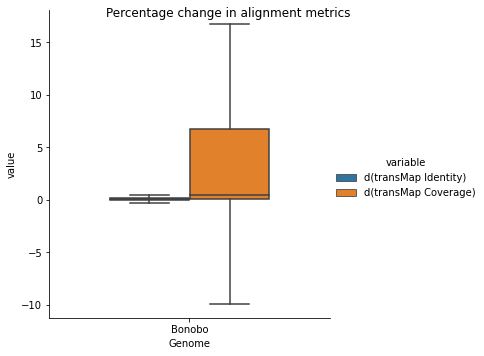

In [15]:
g = sns.catplot(data=m[m.value != 0], kind='box', x='Genome', y='value', hue='variable',
            showfliers=False, sharey=False, order=genomes, hue_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

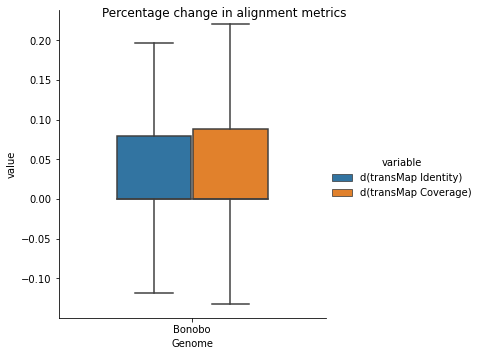

In [20]:
g = sns.catplot(data=m, kind='box', x='Genome', y='value', hue='variable',
            showfliers=False, sharey=False, order=genomes, hue_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

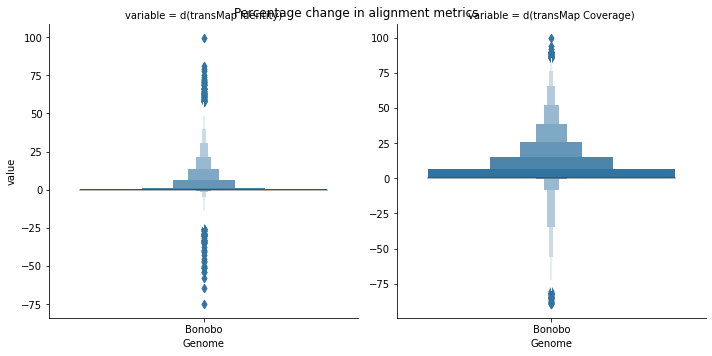

In [14]:
g = sns.catplot(data=m[m.value != 0], kind='boxen', x='Genome', y='value', col='variable',
             sharey=False, order=genomes, col_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

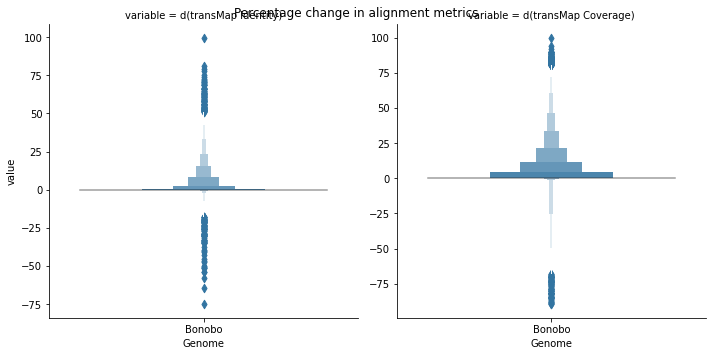

In [21]:
g = sns.catplot(data=m, kind='boxen', x='Genome', y='value', col='variable',
             sharey=False, order=genomes, col_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

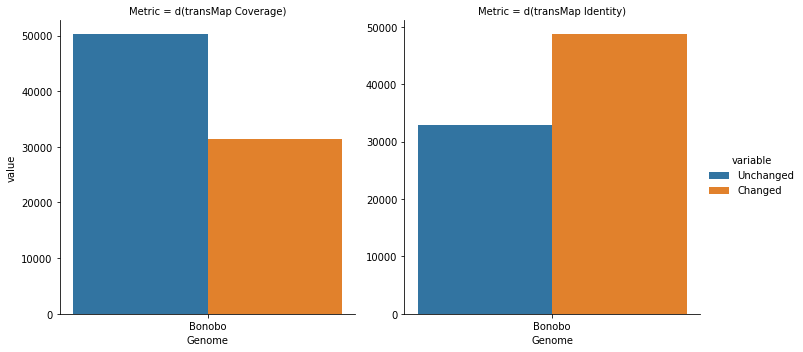

In [16]:
counts = []
for (genome, variable), d in m.groupby(['Genome', 'variable']):
    num_zero = len(d[d.value == 0])
    num_nonzero = len(d) - num_zero
    tot = len(d)
    counts.append([genome, variable, num_zero, num_nonzero])
cdf = pd.DataFrame(counts, columns=['Genome', 'Metric', 'Unchanged', 'Changed'])
cdf = cdf.melt(id_vars=['Genome', 'Metric'])
sns.catplot(data=cdf, hue='variable', y='value', x='Genome', col='Metric', kind='bar', sharey=False)

In [69]:
import numpy as np
m.groupby("variable").aggregate(np.mean)

,value
variable,
d(transMap Coverage),2.073341
d(transMap Identity),0.763984


In [54]:
counts_df = pd.DataFrame(counts, columns=["Genome", "Metric", "Num Unchanged", "Num Changed"])
counts_df["Total"] = counts_df["Num Unchanged"] + counts_df['Num Changed']
counts_df["Change Frac"] = counts_df["Num Changed"]
counts_df

,Genome,Metric,Num Unchanged,Num Changed,Total,Change Frac
0,Bonobo,d(transMap Coverage),50211,31336,81547,31336
1,Bonobo,d(transMap Identity),32858,48689,81547,48689


In [56]:
flnc = glob('/public/groups/cgl/cat/primates_evan/isoseq/*/*fasta')

bam_map = defaultdict(list)

for f in flnc:
    g = f.split('/')[-2].split('_')[0]
    g = g.title()
    if g != 'Bonobo':
        continue
    new_bam = f.replace('fasta', 'sorted.bam')
    assert os.path.exists(new_bam)
    n = os.path.basename(f).split(".")[0]
    old_bam = os.path.join("/public/groups/cgl/cat/primates_evan/v2/original-bonobo", n + ".sorted.bam")
    assert os.path.exists(old_bam)
    bam_map[g].append([new_bam, old_bam])

In [58]:
def filter_bam(bam):
    for rec in pysam.Samfile(bam):
        if not rec.is_supplementary and not rec.is_secondary and not rec.is_unmapped and rec.seq is not None:
            yield rec
            

def parse_cigar(rec):
    matches = 0
    for op, num_bases in rec.cigar:
        if op == 0:
            matches += num_bases
    return rec.qname, format_ratio(matches, len(rec.seq))


def bam_wapper(bam):
    for rec in filter_bam(bam):
        yield parse_cigar(rec)

In [59]:
metrics = []
for genome, bams in bam_map.items():
    for new_bam, old_bam in bams:
        new_bam = pd.DataFrame(list(bam_wapper(new_bam)), columns=['qname', 'coverage'])
        old_bam = pd.DataFrame(list(bam_wapper(old_bam)), columns=['qname', 'coverage'])
        m = new_bam.merge(old_bam, how='outer', on='qname', suffixes=['_new', '_old'])
        m['genome'] = [genome] * len(m)
        metrics.append(m)

In [60]:
metrics_df = pd.concat(metrics)

In [61]:
metrics_df['d(IsoSeq Coverage)'] = 100 * (metrics_df['coverage_new'] - metrics_df['coverage_old'])

In [62]:
m_iso = metrics_df[['d(IsoSeq Coverage)', 'genome']].melt(id_vars=['genome'])

In [63]:
m_iso.columns = ['Genome', 'variable', 'value']

In [70]:
combined = pd.concat([m_iso, m])

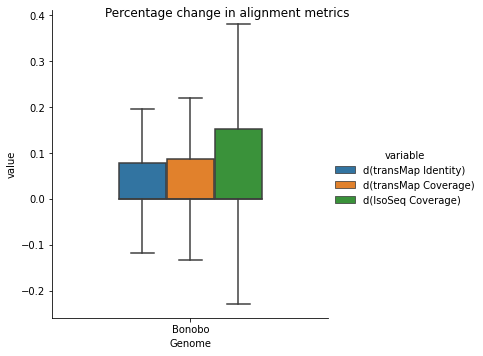

In [73]:
g = sns.catplot(data=combined, kind='box', x='Genome', y='value', hue='variable',
            showfliers=False, sharey=False, order=genomes, hue_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)', 'd(IsoSeq Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

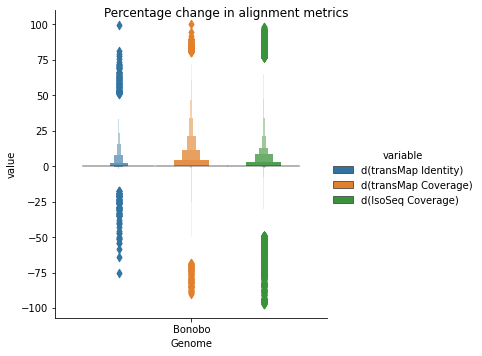

In [74]:
g = sns.catplot(data=combined, kind='boxen', x='Genome', y='value', hue='variable',
             sharey=False, order=genomes, hue_order=['d(transMap Identity)', 
                                                                      'd(transMap Coverage)', 'd(IsoSeq Coverage)'])
_ = g.fig.suptitle('Percentage change in alignment metrics')

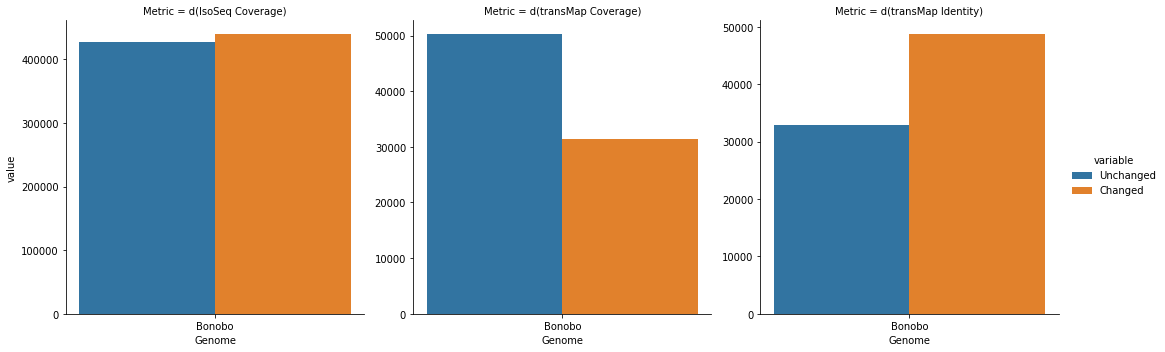

In [72]:
counts = []
for (genome, variable), d in combined.groupby(['Genome', 'variable']):
    num_zero = len(d[d.value == 0])
    num_nonzero = len(d) - num_zero
    tot = len(d)
    counts.append([genome, variable, num_zero, num_nonzero])
cdf = pd.DataFrame(counts, columns=['Genome', 'Metric', 'Unchanged', 'Changed'])
cdf = cdf.melt(id_vars=['Genome', 'Metric'])
sns.catplot(data=cdf, hue='variable', y='value', x='Genome', col='Metric', kind='bar', sharey=False)

In [75]:
m_iso.groupby("variable").aggregate(np.mean)

,value
variable,
d(IsoSeq Coverage),1.56181


In [77]:
counts_df = pd.DataFrame(counts, columns=["Genome", "Metric", "Num Unchanged", "Num Changed"])
counts_df["Total"] = counts_df["Num Unchanged"] + counts_df['Num Changed']
counts_df["Change Frac"] = counts_df["Num Changed"] / counts_df["Total"]
counts_df

,Genome,Metric,Num Unchanged,Num Changed,Total,Change Frac
0,Bonobo,d(IsoSeq Coverage),427778,439333,867111,0.506663
1,Bonobo,d(transMap Coverage),50211,31336,81547,0.384269
2,Bonobo,d(transMap Identity),32858,48689,81547,0.597067
